In [1]:
!pip uninstall -y torch torchvision xformers
!pip install torch==2.5.1 torchvision==0.20.1 --index-url https://download.pytorch.org/whl/cu121
!pip install xformers==0.0.27.post2
!pip install diffusers[torch] transformers accelerate bitsandbytes --upgrade

Found existing installation: torch 2.7.1+cu118
Uninstalling torch-2.7.1+cu118:
  Successfully uninstalled torch-2.7.1+cu118
Found existing installation: torchvision 0.22.1+cu118
Uninstalling torchvision-0.22.1+cu118:
  Successfully uninstalled torchvision-0.22.1+cu118


Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 4.8 MB/s eta 0:08:30
     ---------------------------------------- 0.0/2.4 GB 4.8 MB/s eta 0:08:31
     ---------------------------------------- 0.0/2.4 GB 4.7 MB/s eta 0:08:45
     ---------------------------------------- 0.0/2.4 GB 4.6 MB/s eta 0:08:47
     ---------------------------------------- 0.0/2.4 GB 4.6 MB/s eta 0:08:52
     ---------------------------------------- 0.0/2.4 GB 4.6 MB/s eta 0:08:54
     ---------------------------------------- 0.0/2.4 GB 4.7 MB/s eta 0:08:39
     ---------------------------------------- 0.0/2.4 GB 4.9 MB/s eta 0:08:20
     ---------------------------------------- 0.0/2.4 GB 4.9 MB/s eta 0:08:17
     ---------------------------------------- 0.0/2.4 GB 5.0 MB/s eta 0:08:05
     ---------------------------------------- 0.0/2.4 GB 5.1 MB/s eta 0:07:59
     -------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.20.1+cu121 requires torch==2.5.1+cu121, but you have torch 2.4.0 which is incompatible.


   ---------------------------------------- 0.0/60.7 MB ? eta -:--:--
    --------------------------------------- 1.0/60.7 MB 6.3 MB/s eta 0:00:10
   - -------------------------------------- 2.6/60.7 MB 6.9 MB/s eta 0:00:09
   -- ------------------------------------- 3.9/60.7 MB 6.5 MB/s eta 0:00:09
   --- ------------------------------------ 5.2/60.7 MB 6.5 MB/s eta 0:00:09
   ---- ----------------------------------- 6.6/60.7 MB 6.4 MB/s eta 0:00:09
   ----- ---------------------------------- 7.9/60.7 MB 6.5 MB/s eta 0:00:09
   ------ --------------------------------- 9.2/60.7 MB 6.3 MB/s eta 0:00:09
   ------ --------------------------------- 10.2/60.7 MB 6.2 MB/s eta 0:00:09
   ------- -------------------------------- 11.5/60.7 MB 6.2 MB/s eta 0:00:08
   -------- ------------------------------- 13.1/60.7 MB 6.2 MB/s eta 0:00:08
   --------- ------------------------------ 14.2/60.7 MB 6.2 MB/s eta 0:00:08
   ---------- ----------------------------- 15.7/60.7 MB 6.3 MB/s eta 0:00:08
 

In [1]:
# --- 1. SETUP AND INSTALLATIONS ---
# Install necessary libraries for the project
!pip install diffusers transformers accelerate torch torchvision bitsandbytes --quiet
!pip install kaggle --quiet

# Import libraries
import os
import torch
import pandas as pd
from google.colab import files
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import StableDiffusionPipeline, UNet2DConditionModel, DDPMScheduler, AutoencoderKL
from diffusers.optimization import get_scheduler
from google.colab import drive

print("--- Setup Complete ---")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.6.0 requires torch==2.6.0, but you have torch 2.5.1 which is incompatible.
xformers 0.0.27.post2 requires torch==2.4.0, but you have torch 2.5.1 which is incompatible.


/usr/local/lib/python3.11/dist-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/usr/local/lib/python3.11/dist-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


--- Setup Complete ---


In [5]:
# @title 2. Mount Drive and Unzip Your Dataset

# Mount Google Drive to save your fine-tuned model permanently
drive.mount('/content/drive')

# Unzip your dataset from Drive into the Colab session
# IMPORTANT: Make sure your .zip file is in your Google Drive's main folder
zip_path = '/content/drive/MyDrive/marketing_dataset.zip' # Or your .zip file's name
extract_path = '/content/dataset/'

print("\n➡️ Unzipping dataset...")
if os.path.exists(zip_path):
    !unzip -q "{zip_path}" -d "{extract_path}"
    print(f"✅ Dataset successfully unzipped to {extract_path}")
else:
    print(f"⚠️ ERROR: ZIP file not found at {zip_path}. Please upload your dataset to Google Drive.")

# IMPORTANT: Set this to the top-level folder that was inside your .zip file.
# For example: /content/dataset/your_main_folder_name
DATASET_ROOT_DIR = "/content/dataset/marketing_dataset"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

➡️ Unzipping dataset...
replace /content/dataset/marketing_dataset/coffee_brands/11636812.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace /content/dataset/marketing_dataset/coffee_brands/11636813.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace /content/dataset/marketing_dataset/coffee_brands/aakash-goel-LYkpdP46NUw-unsplash.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace /content/dataset/marketing_dataset/coffee_brands/airam-dato-on-51fofnV_dr4-unsplash.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace /content/dataset/marketing_dataset/coffee_brands/cemrecan-yurtman-CDBA3TXBOrc-unsplash.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace /content/dataset/marketing_dataset/coffee_brands/cemrecan-yurtman-KIBY9_xdEoc-unsplash.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
replace /content/dataset/marketing_dataset/coffee_brands/cla

In [6]:
# @title 3. Create Metadata File with Marketing Captions
print("--- Preparing metadata for the marketing dataset ---")

image_files = []
captions = []

# Iterate through each brand category directory
for category in os.listdir(DATASET_ROOT_DIR):
    category_path = os.path.join(DATASET_ROOT_DIR, category)
    if os.path.isdir(category_path):
        for img_file in os.listdir(category_path):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(category, img_file))

                # Create professional, marketing-focused captions from the folder name
                product_name = category.replace('_', ' ').replace('brands', '').strip()
                caption = f"professional product photography of {product_name}, studio lighting, high quality, 4k, on a clean background"
                captions.append(caption)

# Create a DataFrame and save it to metadata.csv
metadata_df = pd.DataFrame({
    'file_name': image_files,
    'caption': captions
})
metadata_df.to_csv(os.path.join(DATASET_ROOT_DIR, 'metadata.csv'), index=False)

print(f"--- Created metadata.csv with {len(metadata_df)} entries ---")

--- Preparing metadata for the marketing dataset ---
--- Created metadata.csv with 317 entries ---


In [8]:
from tqdm.auto import tqdm

In [9]:
# @title 4. Define Custom Dataset and DataLoader
class ProductDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.captions_df = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

        # Filter out any corrupted or missing images
        valid_entries = []
        print("Verifying images...")
        for idx in tqdm(range(len(self.captions_df))):
            img_path = os.path.join(self.image_dir, self.captions_df.iloc[idx, 0])
            if os.path.exists(img_path):
                try:
                    with Image.open(img_path) as img:
                        img.verify() # Check if image is valid
                    valid_entries.append(idx)
                except:
                    continue
        self.captions_df = self.captions_df.iloc[valid_entries].reset_index(drop=True)
        print(f"Found {len(self.captions_df)} valid images.")

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.captions_df.iloc[idx, 0])
        try:
            image = Image.open(img_name).convert("RGB")
        except:
            image = Image.new('RGB', (512, 512), (0, 0, 0))
        caption = self.captions_df.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return {"image": image, "caption": caption}

# Image transformations
preprocess = transforms.Compose([
    transforms.Resize(512, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(512),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# Create a limited dataset for efficient training
max_training_images = 1000 # You can adjust this for more/less training

metadata_df = pd.read_csv(os.path.join(DATASET_ROOT_DIR, 'metadata.csv'))
print(f"Total images available: {len(metadata_df)}")

if len(metadata_df) > max_training_images:
    limited_metadata = metadata_df.sample(n=max_training_images, random_state=42).reset_index(drop=True)
    print(f"Using {max_training_images} randomly selected images for training.")
else:
    limited_metadata = metadata_df
    print(f"Using all {len(metadata_df)} images for training.")

# Save the limited metadata to a temporary file
limited_metadata_path = os.path.join(DATASET_ROOT_DIR, 'limited_metadata.csv')
limited_metadata.to_csv(limited_metadata_path, index=False)

# Create the dataset with the limited metadata
train_dataset = ProductDataset(
    csv_file=limited_metadata_path,
    image_dir=DATASET_ROOT_DIR,
    transform=preprocess
)

# Create the dataloader
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
print(f"--- Training dataloader created with {len(train_dataloader)} batches ---")

Total images available: 317
Using all 317 images for training.
Verifying images...


  0%|          | 0/317 [00:00<?, ?it/s]

Found 317 valid images.
--- Training dataloader created with 317 batches ---


In [11]:
from huggingface_hub import notebook_login

notebook_login()

In [16]:
# Try to install xformers for memory efficiency and define the variable
try:
    !pip install xformers --quiet
    XFORMERS_AVAILABLE = True
    print("XFormers installed successfully")
except:
    XFORMERS_AVAILABLE = False
    print("XFormers not available, using standard attention")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 380.4 kB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.6.0 requires torch==2.6.0, but you have torch 2.4.0 which is incompatible.
torchvision 0.20.

In [17]:
# @title 5. Configure Model and Training Parameters

# This is a highly stable base model, as used in your reference notebook.
pretrained_model_name = "runwayml/stable-diffusion-v1-5"
output_dir = "/content/drive/MyDrive/GenAI_Project/MarketingModel_LoRA"
os.makedirs(output_dir, exist_ok=True)

# Training parameters from the reference notebook
learning_rate = 1e-5
num_train_epochs = 3
train_batch_size = 1
gradient_accumulation_steps = 4

# Load the pretrained model components
print("--- Loading pretrained model ---")
pipeline = StableDiffusionPipeline.from_pretrained(
    pretrained_model_name,
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False,
    use_safetensors=True
)

# Move components to CUDA and set up for training
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder.to("cuda", dtype=torch.float16)
vae = pipeline.vae.to("cuda", dtype=torch.float16)
unet = pipeline.unet.to("cuda", dtype=torch.float16)
scheduler = DDPMScheduler.from_config(pipeline.scheduler.config)

# Enable memory efficient attention if XFormers is available
if XFORMERS_AVAILABLE:
    try:
        unet.enable_xformers_memory_efficient_attention()
        print("XFormers memory efficient attention enabled")
    except Exception as e:
        print(f"Could not enable XFormers: {e}. Using attention slicing.")
        unet.set_attention_slice("auto")
else:
    print("Using attention slicing for memory efficiency")
    unet.set_attention_slice("auto")

print("--- Model loaded successfully ---")

--- Loading pretrained model ---


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

XFormers memory efficient attention enabled
--- Model loaded successfully ---


In [19]:
from peft import LoraConfig, get_peft_model

In [20]:
# @title 6. Set up LoRA for Efficient Fine-Tuning
print("--- Setting up LoRA ---")

# Freeze the original parameters
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
unet.requires_grad_(False)

# Configure LoRA
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.1,
)

# Apply LoRA to the UNet
unet = get_peft_model(unet, lora_config)
unet.print_trainable_parameters()

# Setup optimizer for LoRA parameters only
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)

# Learning rate scheduler
total_steps = len(train_dataloader) * num_train_epochs
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=total_steps,
)

print("--- LoRA setup complete ---")

--- Setting up LoRA ---
trainable params: 3,188,736 || all params: 862,709,700 || trainable%: 0.3696
--- LoRA setup complete ---


In [22]:
import torch.nn.functional as F

In [23]:
# @title 7. Start the Training Loop
print("--- Starting Training ---")
unet.enable_gradient_checkpointing()
unet.train()
vae.eval()
text_encoder.eval()

global_step = 0
max_train_steps = len(train_dataloader) * num_train_epochs

for epoch in range(num_train_epochs):
    print(f"--- Epoch {epoch + 1}/{num_train_epochs} ---")
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")

    for step, batch in enumerate(progress_bar):
        with torch.no_grad():
            latents = vae.encode(batch["image"].to("cuda", dtype=torch.float16)).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

        noise = torch.randn_like(latents)
        bsz = latents.shape[0]
        timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bsz,), device=latents.device).long()

        noisy_latents = scheduler.add_noise(latents, noise, timesteps)

        with torch.no_grad():
            tokenized_captions = tokenizer(
                batch["caption"],
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt"
            ).input_ids.to("cuda")
            encoder_hidden_states = text_encoder(tokenized_captions)[0]

        target = noise

        # Predict the noise residual
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]
        loss = F.mse_loss(model_pred.float(), target.float(), reduction="mean")

        if torch.isnan(loss):
            print(f"NaN loss detected at step {global_step}, skipping...")
            continue

        loss.backward()

        if (global_step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        progress_bar.set_postfix(loss=loss.detach().item())
        global_step += 1

print("--- Training Finished ---")

--- Starting Training ---
--- Epoch 1/3 ---


Epoch 1:   0%|          | 0/317 [00:00<?, ?it/s]

--- Epoch 2/3 ---


Epoch 2:   0%|          | 0/317 [00:00<?, ?it/s]

--- Epoch 3/3 ---


Epoch 3:   0%|          | 0/317 [00:00<?, ?it/s]

--- Training Finished ---



--- Interactive Mode ---
Test your fine-tuned marketing model with custom prompts!

Tips for better results:
- Be specific: 'a bottle of Dior perfume on a wet marble surface with splashing water'
- Add style words: 'studio quality', 'cinematic lighting', 'professional photography', '4k'
- Mention the background: 'on a clean white background', 'in a minimalist setting with soft shadows'
------------------------------------------------------------

Enter your prompt for a product image (type 'quit' to exit): i want to advertis apple's brand new mac book 
Generating image for: 'i want to advertis apple's brand new mac book '


  0%|          | 0/50 [00:00<?, ?it/s]

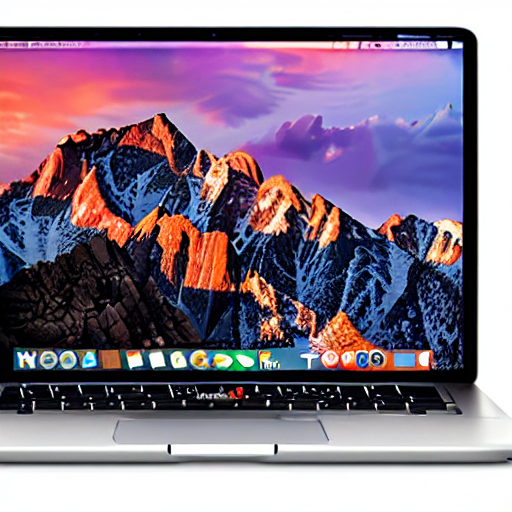

Save this image? (y/n): y
Enter filename (without extension): ads
Image saved as ads.png

Enter your prompt for a product image (type 'quit' to exit): quit
--- Interactive testing ended ---


In [28]:
# @title 8. Test Your Model Interactively
print("\n--- Interactive Mode ---")
print("Test your fine-tuned marketing model with custom prompts!")
print("\nTips for better results:")
print("- Be specific: 'a bottle of Dior perfume on a wet marble surface with splashing water'")
print("- Add style words: 'studio quality', 'cinematic lighting', 'professional photography', '4k'")
print("- Mention the background: 'on a clean white background', 'in a minimalist setting with soft shadows'")
print("-" * 60)

unet.eval() # Set model to evaluation mode

def generate_product_image(prompt, num_inference_steps=50, guidance_scale=7.5):
    """Generates an image using the fine-tuned LoRA model."""
    with torch.no_grad():
        image = pipeline(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=torch.manual_seed(42) # For reproducible results
        ).images[0]
    return image

while True:
    test_prompt = input("\nEnter your prompt for a product image (type 'quit' to exit): ")
    if test_prompt.lower() == 'quit':
        break

    # Enhance the prompt if it's too simple, similar to the reference notebook
    enhanced_prompt = test_prompt
    if len(test_prompt.split()) < 6:
        enhanced_prompt += ", professional product photography, studio lighting, 4k"

    print(f"Generating image for: '{enhanced_prompt}'")

    try:
        generated_image = generate_product_image(enhanced_prompt)
        display(generated_image)

        save_choice = input("Save this image? (y/n): ")
        if save_choice.lower() == 'y':
            filename = input("Enter filename (without extension): ").strip()
            if filename:
                generated_image.save(f"/content/{filename}.png")
                print(f"Image saved as {filename}.png")

    except Exception as e:
        print(f"An error occurred: {str(e)}")

print("--- Interactive testing ended ---")

In [29]:
# @title 9. Save the LoRA Model Weights
print("\n" + "="*60)
print("TRAINING AND TESTING COMPLETE!")
print("="*60)

save_model = input("\nAre you satisfied with the results and want to save the LoRA weights? (y/n): ")
if save_model.lower() == 'y':
    print("--- Saving the fine-tuned LoRA model weights ---")
    unet.save_pretrained(output_dir)
    print(f"✅ Model weights saved successfully to your Google Drive at: {output_dir}")
else:
    print("Model not saved.")


TRAINING AND TESTING COMPLETE!

Are you satisfied with the results and want to save the LoRA weights? (y/n): y
--- Saving the fine-tuned LoRA model weights ---
✅ Model weights saved successfully to your Google Drive at: /content/drive/MyDrive/GenAI_Project/MarketingModel_LoRA
